# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT THÀNH PHỐ HỒ CHÍ MINH
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY ĐỂ DỰ ĐOÁN GIÁ NÔNG SẢN

Sinh viên 1: Huỳnh Hạo Nhị - 20133006

Sinh viên 2: Võ Hoài Thương - 20233012

# Thư viện

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# Dữ liệu

## Giá xoài

Dữ liệu giá xoài được thu thập của tỉnh An Giang, từ website của Viện Chính sách và Chiến lược Phát triển Nông nghiệp Nông thôn từ năm 2007 đến nay.
*   date*: ngày
*   price: giá xoài


In [ ]:
df_mango = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Xoai/gia_xoai.csv', encoding='ISO-8859-1')
df_mango.tail()

,date,price
3459,5/10/2024,25000
3460,5/11/2024,25000
3461,5/12/2024,25000
3462,5/13/2024,25000
3463,5/14/2024,25000


In [ ]:
df_mango.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3464 entries, 0 to 3463
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3464 non-null   object
 1   price   3464 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.2+ KB


In [ ]:
df_mango['date'] = pd.to_datetime(df_mango['date'])
df_mango.set_index('date', inplace=True)

### Điền dữ liệu ngày thiếu

In [ ]:
idx = pd.date_range(df_mango.index.min(), df_mango.index.max())
df_mango = df_mango.reindex(idx)
df_mango.fillna(method='ffill', inplace=True)
df_mango.tail()

,price
2024-05-10,25000
2024-05-11,25000
2024-05-12,25000
2024-05-13,25000
2024-05-14,25000


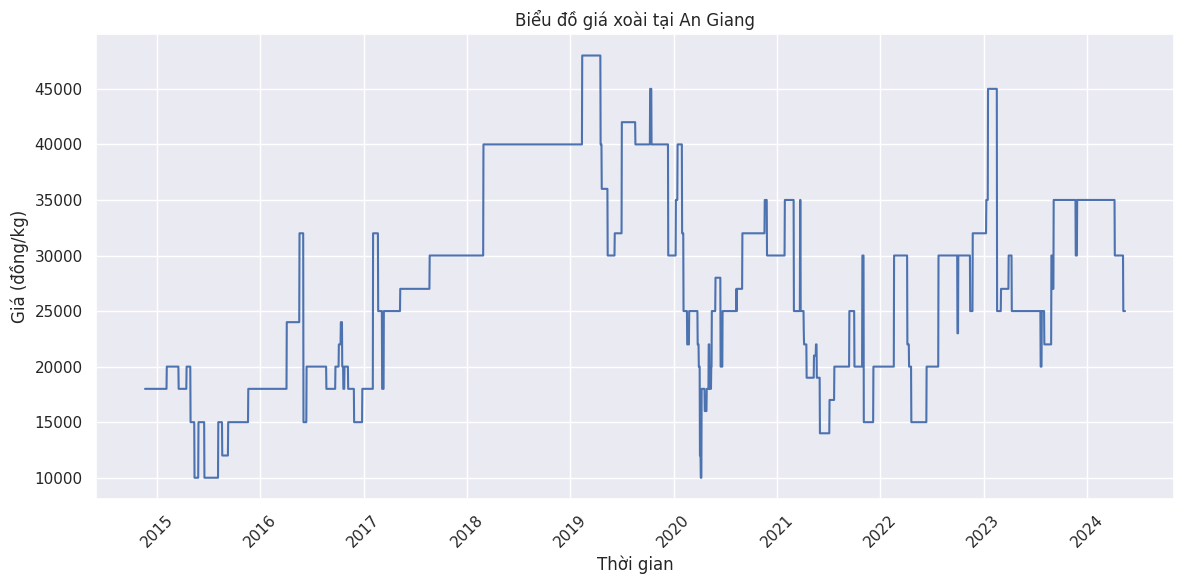

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_mango, x=df_mango.index, y='price')
plt.title('Biểu đồ giá xoài tại An Giang')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Giá xăng

Dữ liệu giá xăng thu thập từ website của Công ty Dầu Việt Nam – CTCP.
*   date*: ngày
*   RON 95-III: giá xăng Ron 95-III

In [ ]:
df_gasoline = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Xang/gia_xang.csv', encoding='ISO-8859-1')
df_gasoline.tail()

,date,RON 95-III
170,2/5/2024,24.95
171,9/5/2024,23.54
172,16/05/2024,23.13
173,23/05/2024,23.21
174,29/05/2024,23.21


### Xử lý outlier

<Axes: >

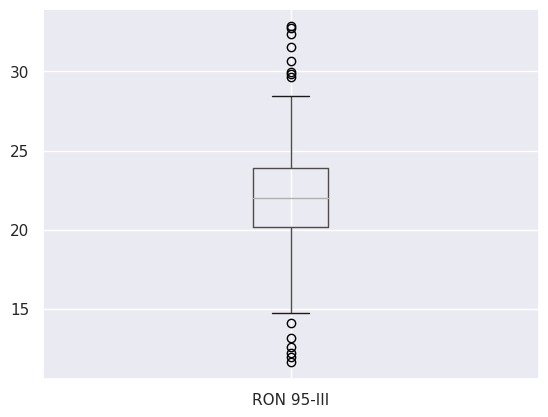

In [ ]:
df_gasoline[['RON 95-III']].boxplot()

In [ ]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_gasoline['RON 95-III'].quantile(0.25)
Q3 = df_gasoline['RON 95-III'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_gasoline[(df_gasoline['RON 95-III'] < lower_bound) | (df_gasoline['RON 95-III'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

Số lượng outlier: 14


In [ ]:
# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_gasoline.at[df_gasoline.index[0], 'RON 95-III'] = min(max(df_gasoline.iloc[0]['RON 95-III'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_gasoline.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_gasoline.index[previous_date_index]
        previous_value = df_gasoline.loc[previous_date, 'RON 95-III']
        df_gasoline.at[index, 'RON 95-III'] = previous_value

<Axes: >

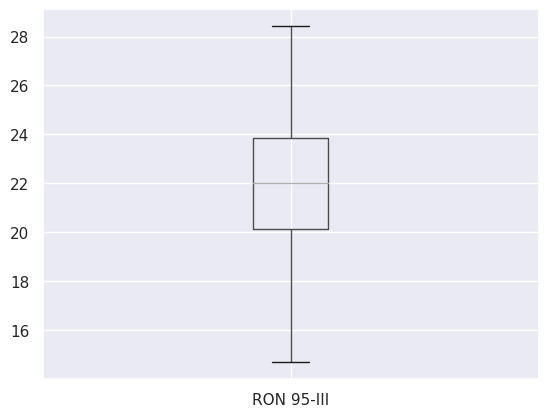

In [ ]:
df_gasoline[['RON 95-III']].boxplot()

### Fill dữ liệu ngày bị thiếu

In [ ]:
df_gasoline['date'] = pd.to_datetime(df_gasoline['date'])
df_gasoline.set_index('date', inplace=True)

<ipython-input-121-2ca4586e2886>:1: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [ ]:
idx = pd.date_range(df_gasoline.index.min(), df_gasoline.index.max())
df_gasoline = df_gasoline.reindex(idx)
df_gasoline.fillna(method='ffill', inplace=True)

### Merge dữ liệu xăng với xoài

In [ ]:
start_date = df_gasoline.index.min()
df_mango_filtered = df_mango.loc[start_date:]

df_merged_gasoline = pd.merge(df_mango_filtered, df_gasoline[['RON 95-III']], left_index=True, right_index=True, how='left')
df_merged_gasoline['RON 95-III'] = df_merged_gasoline['RON 95-III'].ffill()

print(df_merged_gasoline.tail())

            price  RON 95-III
2024-05-10  25000       23.54
2024-05-11  25000       23.54
2024-05-12  25000       23.54
2024-05-13  25000       23.54
2024-05-14  25000       23.54


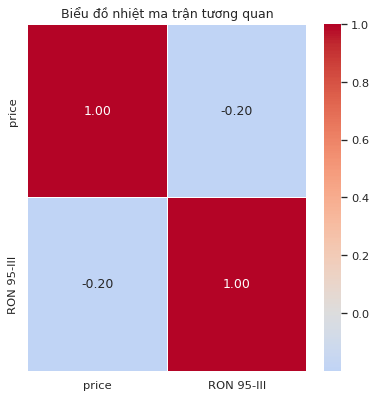

In [ ]:
correlation_matrix = df_merged_gasoline.corr()

plt.figure(figsize=(6, 6), dpi=75)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm', center=0)
plt.title('Biểu đồ nhiệt ma trận tương quan')
plt.show()

In [ ]:
# df_merged_gasoline.to_csv('gia_xoai_xang.csv', index=True)

### Làm mịn dữ liệu

In [ ]:
df_merged_gasoline = df_merged_gasoline.rolling(window=30, min_periods=1).mean()

# Mô hình LSTM dự đoán

Mạng LSTM (Long Short-Term Memory) là mạng nơ-ron hồi quy có khả năng xử lý chuỗi thời gian dài hạn với cấu trúc gồm ba cổng:
*   Cổng quên (f): xác định thông tin nào của trạng thái tạm thời cũ được lưu trữ hoặc loại bỏ bằng hàm sigmoid.
*   Cổng nhập (i): xác định thông tin được thêm vào trạng thái tạm thời bằng hàm sigmoid.
*   Cổng xuất (o): xác định thông tin được xuất làm đầu ra của mạng LSTM hàm sigmoid.
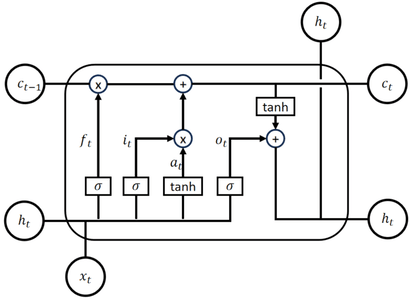

## Giá cà phê kết hợp giá xăng

### Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Preprocess data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(df_merged_gasoline[['price']])

scaler_export = MinMaxScaler(feature_range=(0, 1))
scaled_export = scaler_export.fit_transform(df_merged_gasoline[['RON 95-III']])

scaled_data = np.concatenate((scaled_price, scaled_export), axis=1)

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
X.shape, y.shape

((2063, 30, 2), (2063,))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (1650, 30, 2) (1650,)
Kích thước tập kiểm tra: (413, 30, 2) (413,)


In [ ]:
model_gasoline = Sequential()
# model_gasoline.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, 2)))
model_gasoline.add(LSTM(units=128, input_shape=(seq_length, 2)))
model_gasoline.add(Dropout(0.2))
model_gasoline.add(Dense(units=1))

In [ ]:
model_gasoline.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model_gasoline.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
26/26 [==============================] - 4s 42ms/step - loss: 0.0524
Epoch 2/50
26/26 [==============================] - 1s 45ms/step - loss: 0.0043
Epoch 3/50
26/26 [==============================] - 1s 44ms/step - loss: 0.0028
Epoch 4/50
26/26 [==============================] - 1s 45ms/step - loss: 0.0024
Epoch 5/50
26/26 [==============================] - 2s 64ms/step - loss: 0.0022
Epoch 6/50
26/26 [==============================] - 2s 87ms/step - loss: 0.0020
Epoch 7/50
26/26 [==============================] - 1s 57ms/step - loss: 0.0017
Epoch 8/50
26/26 [==============================] - 1s 45ms/step - loss: 0.0017
Epoch 9/50
26/26 [==============================] - 1s 48ms/step - loss: 0.0015
Epoch 10/50
26/26 [==============================] - 1s 46ms/step - loss: 0.0013
Epoch 11/50
26/26 [==============================] - 1s 43ms/step - loss: 0.0014
Epoch 12/50
26/26 [==============================] - 1s 42ms/step - loss: 0.0013
Epoch 13/50
26/26 [==================

### Dự đoán trên tập train

In [ ]:
train_predictions = model_gasoline.predict(X_train)

52/52 [==============================] - 1s 12ms/step


In [ ]:
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train = scaler_price.inverse_transform(y_train.reshape(-1, 1))

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 454.55
Training MAPE: 1.30%


In [ ]:
dates = df_merged_gasoline.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá xoài trên tập huấn luyện (mô hình LSTM, dữ liệu giá xoài và giá xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Dự đoán trên tập test

In [ ]:
test_predictions = model_gasoline.predict(X_test)

13/13 [==============================] - 0s 12ms/step


In [ ]:
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {test_mape:.2f}%')

Testing RMSE: 377.14
Testing MAPE: 1.03%


In [ ]:
dates = df_merged_gasoline.index.tolist()
test_dates = dates[-len(y_test):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=test_dates, y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá xoài trên tập kiểm tra (mô hình LSTM, dữ liệu giá xoài và giá xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

            RMSE  MAPE (%)
0  Train  454.55      1.30
1   Test  377.14      1.03


### Lưu mô hình

In [ ]:
model_gasoline.save('LSTM_gia_xoai_xang.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

